# Final Project Code

## Dataset

In [4]:
!pip install kagglehub

In [5]:
import kagglehub
# Download latest version
# add '/Data' to the end to properly access the underlying images
DATA_DIR = kagglehub.dataset_download("satyaprakash138/balanced-malware-image-dataset") + "/Data"

print("Path to dataset files:", DATA_DIR)

100%|██████████| 1.13G/1.13G [00:31<00:00, 38.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/satyaprakash138/balanced-malware-image-dataset/versions/1/Data


### ML Library Dependencies

In [6]:
!pip install -q skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 11.2 MB/s eta 0:00:00


In [7]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

# for SVM-LS
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelBinarizer

In [8]:
IMAGE_SIZE = 64


transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dir = os.path.join(DATA_DIR, "train")
test_dir = os.path.join(DATA_DIR, "test")
val_dir = os.path.join(DATA_DIR, "val")

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

print("Train classes:", train_dataset.classes)
print("Val   classes:", val_dataset.classes)
print("Test  classes:", test_dataset.classes)
print("Num train:", len(train_dataset), "Num val:", len(val_dataset), "Num test:", len(test_dataset))

num_classes = len(train_dataset.classes)



Train classes: ['MaliciousImages', 'NormalImages']
Val   classes: ['MaliciousImages', 'NormalImages']
Test  classes: ['MaliciousImages', 'NormalImages']
Num train: 17066 Num val: 2438 Num test: 4876


In [9]:
def dataset_to_numpy(ds):
  X_list, y_list = [], []
  for img, label in ds:
    X_list.append(img.numpy())
    y_list.append(label)
  X = np.stack(X_list).astype("float32")
  y = np.array(y_list).astype("int64")

  return X, y


In [10]:
X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:",   X_val.shape,   "y_val:",   y_val.shape)
print("X_test:",  X_test.shape,  "y_test:",  y_test.shape)

X_train: (17066, 1, 64, 64) y_train: (17066,)
X_val: (2438, 1, 64, 64) y_val: (2438,)
X_test: (4876, 1, 64, 64) y_test: (4876,)


### CNN Feature Extraction for KNN, SVM, SVM-LS

In [38]:
class FeatureExtractorCNN(nn.Module):
    def __init__(self, num_classes=25):
        super(FeatureExtractorCNN, self).__init__()
        # 1 channel, 32 convolutional filters, 3x3 kernel
        # stride 1, padding 1 to preserve spatial size
        # ReLU for nonlinearity
        # maxpool downsamples by getting max value in 2x2
        # repeat steps for 64 filters and 128 filters
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def get_features(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

def train_model(model, train_loader, val_loader, epochs=25, patience=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # train
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_epoch = running_loss / len(train_loader)
        train_losses.append(train_loss_epoch)

        # val
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
        val_loss_epoch = val_loss / len(val_loader)
        val_losses.append(val_loss_epoch)

        print(f"Epoch {epoch+1}, Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}")

        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        model.train()

    return train_losses, val_losses

def train_model_quick(model, train_loader, val_loader, epochs=20, patience=2, subset_ratio=0.3):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_loss = float('inf')
    patience_counter = 0

    # Subset the train and val loaders
    train_subset_size = int(len(train_loader.dataset) * subset_ratio)
    val_subset_size = int(len(val_loader.dataset) * subset_ratio)
    train_indices = torch.randperm(len(train_loader.dataset))[:train_subset_size]
    val_indices = torch.randperm(len(val_loader.dataset))[:val_subset_size]
    train_subset = torch.utils.data.Subset(train_loader.dataset, train_indices)
    val_subset = torch.utils.data.Subset(val_loader.dataset, val_indices)
    train_loader_subset = DataLoader(train_subset, batch_size=train_loader.batch_size, shuffle=True)
    val_loader_subset = DataLoader(val_subset, batch_size=val_loader.batch_size, shuffle=False)

    for epoch in range(epochs):
        # train
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader_subset:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss_epoch = running_loss / len(train_loader_subset)
        train_acc_epoch = correct_train / total_train
        train_losses.append(train_loss_epoch)
        train_accs.append(train_acc_epoch)

        # val
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader_subset:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss_epoch = val_loss / len(val_loader_subset)
        val_acc_epoch = correct_val / total_val
        val_losses.append(val_loss_epoch)
        val_accs.append(val_acc_epoch)

        print(f"Epoch {epoch+1}, Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Acc: {train_acc_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        model.train()

    return train_losses, val_losses, train_accs, val_accs


def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in data_loader:
            batch_features = model.get_features(images)
            features.append(batch_features.cpu().numpy())
            labels.append(batch_labels.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

## Train model

In [41]:
# init
model = FeatureExtractorCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# dataloader for CNN, NumPy for KNN, SVM/LS
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses, val_losses, train_accs, val_accs = train_model_quick(model, train_loader, val_loader)

# extract + normalize features
X_train_features, y_train = extract_features(model, train_loader)
X_val_features, y_val = extract_features(model, val_loader)
X_test_features, y_test = extract_features(model, test_loader)

scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_val_features = scaler.transform(X_val_features)
X_test_features = scaler.transform(X_test_features)

Epoch 1, Loss: 0.6305, Val Loss: 0.5721, Acc: 0.6365, Val Acc: 0.7606
Epoch 2, Loss: 0.4895, Val Loss: 0.4696, Acc: 0.7906, Val Acc: 0.7852
Epoch 3, Loss: 0.4398, Val Loss: 0.4456, Acc: 0.8054, Val Acc: 0.7975
Epoch 4, Loss: 0.3905, Val Loss: 0.3928, Acc: 0.8304, Val Acc: 0.8536
Epoch 5, Loss: 0.3277, Val Loss: 0.3284, Acc: 0.8869, Val Acc: 0.8947
Epoch 6, Loss: 0.3209, Val Loss: 0.3175, Acc: 0.8887, Val Acc: 0.8865
Epoch 7, Loss: 0.2863, Val Loss: 0.2956, Acc: 0.9029, Val Acc: 0.9001
Epoch 8, Loss: 0.2815, Val Loss: 0.2736, Acc: 0.9090, Val Acc: 0.8933
Epoch 9, Loss: 0.2873, Val Loss: 0.2923, Acc: 0.8984, Val Acc: 0.8892
Epoch 10, Loss: 0.2722, Val Loss: 0.2623, Acc: 0.9058, Val Acc: 0.9070
Epoch 11, Loss: 0.2641, Val Loss: 0.2567, Acc: 0.9092, Val Acc: 0.9111
Epoch 12, Loss: 0.2616, Val Loss: 0.3041, Acc: 0.9129, Val Acc: 0.8933
Epoch 13, Loss: 0.2572, Val Loss: 0.2792, Acc: 0.9152, Val Acc: 0.9029
Early stopping at epoch 13


Checking CNN feature extraction portion

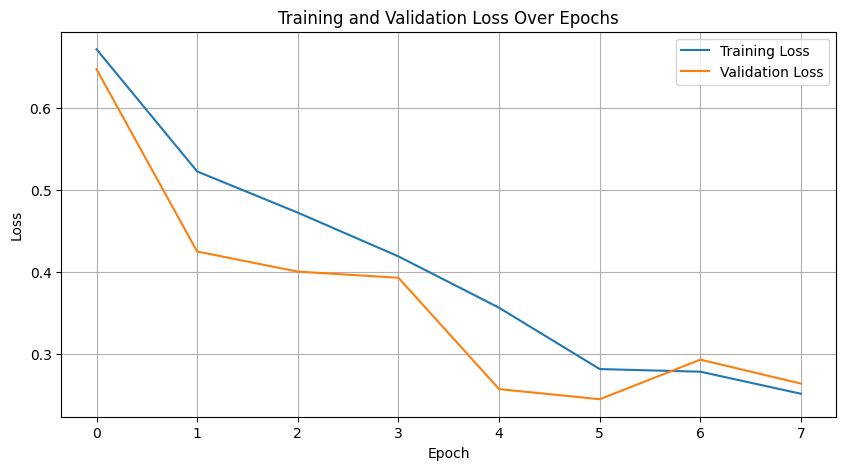

In [36]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

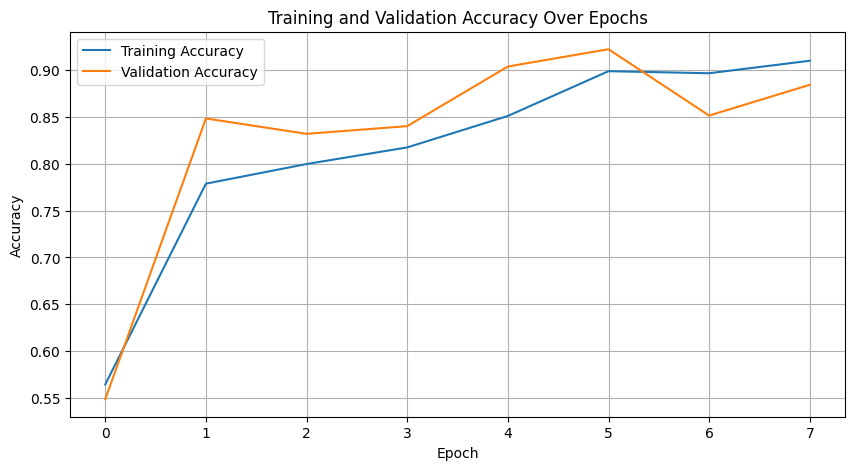

In [37]:
# Plot training and validation accuracy (if you have it)
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, y_train)
y_pred_knn = knn.predict(X_test_features)
print("k-NN Test Accuracy:", accuracy_score(y_test, y_pred_knn))

# SVM
svm = SVC()
svm.fit(X_train_features, y_train)
y_pred_svm = svm.predict(X_test_features)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))

# LS-SVM-style model via Kernel Ridge (one-vs-rest)
lb = LabelBinarizer()
Y_train_bin = lb.fit_transform(y_train)  # shape: (n_samples, n_classes)
Y_test_bin = lb.transform(y_test)

krr = KernelRidge(alpha=1.0, kernel='rbf', gamma=0.01)
krr.fit(X_train_features, Y_train_bin)

Y_pred_scores = krr.predict(X_test_features)          # shape: (n_samples, n_classes)
y_pred_lssvm = Y_pred_scores.argmax(axis=1)
y_pred_lssvm = lb.classes_[y_pred_lssvm]

print("LS-SVM-style Test Accuracy:", accuracy_score(y_test, y_pred_lssvm))

NameError: name 'KNeighborsClassifier' is not defined